# 02 - Exploratory Data Analysis (EDA): Inflation Risk Analysis
**Author:** Namora Fernando  
**Date:** 2025-08-20 <br>
**Objective:** Perform exploratory data analysis (EDA) on the cleaned dataset `cleaned_merged_inflation_data.csv`.  
We will:
1. Understand the structure and quality of the data.  
2. Explore distributions of each indicator.  
3. Visualize temporal trends for selected countries.  
4. Check correlations across indicators.  
5. Identify interesting country-level patterns.  

This step provides the first insights before moving on to **Step 03 (Feature Engineering)**,  
and complements visualization in **Power BI (Step 04)**.

## 1. Introduction
The goal of this notebook is to explore the previously cleaned and merged dataset:  
- Understand the structure using basic statistics.  
- Detect potential data issues.  
- Find early relationships between indicators.  
- Identify cross-country patterns.  

## 2. Setup
Import required libraries and load dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# File path
input_file = "data_intermediate/cleaned_merged_inflation_data.csv"

# Load dataset
df = pd.read_csv(input_file)
df.head()

,Country Name,Country Code,Year,CPI_AnnualChange,GDP_Growth,MoneySupply_GDPpct,ExchangeRate_LCUperUSD
0,Afghanistan,AFG,1960.0,NaN,NaN,NaN,17.196561
1,Afghanistan,AFG,1961.0,NaN,NaN,NaN,17.196561
2,Afghanistan,AFG,1962.0,NaN,NaN,NaN,17.196561
3,Afghanistan,AFG,1963.0,NaN,NaN,NaN,35.109645
4,Afghanistan,AFG,1964.0,NaN,NaN,NaN,38.692262


## 3. Basic Info & Overview
We check data types, descriptive statistics, and missing values.

In [2]:
df.info()
df.describe()

# Missing values per column
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15918 entries, 0 to 15917
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country Name            15918 non-null  object 
 1   Country Code            15918 non-null  object 
 2   Year                    15918 non-null  float64
 3   CPI_AnnualChange        11260 non-null  float64
 4   GDP_Growth              14114 non-null  float64
 5   MoneySupply_GDPpct      10828 non-null  float64
 6   ExchangeRate_LCUperUSD  12308 non-null  float64
dtypes: float64(5), object(2)
memory usage: 870.6+ KB


Country Name                 0
Country Code                 0
Year                         0
CPI_AnnualChange          4658
GDP_Growth                1804
MoneySupply_GDPpct        5090
ExchangeRate_LCUperUSD    3610
dtype: int64

## 4. Univariate Analysis

In this step, we explore each indicator separately to understand its distribution.  
We divide the analysis into three parts:

- **Quick Histograms**: Simple histograms without KDE to get an initial sense of distribution. 
- **KDE with Sampling**: Kernel Density Estimation on a random subset to visualize smoother patterns.
- **Outlier-Capped & Transformed View**: Apply percentile caps and log transformations (when needed) to reduce the influence of extreme outliers and reveal the main structure of the data.

### Quick Histograms (no KDE)

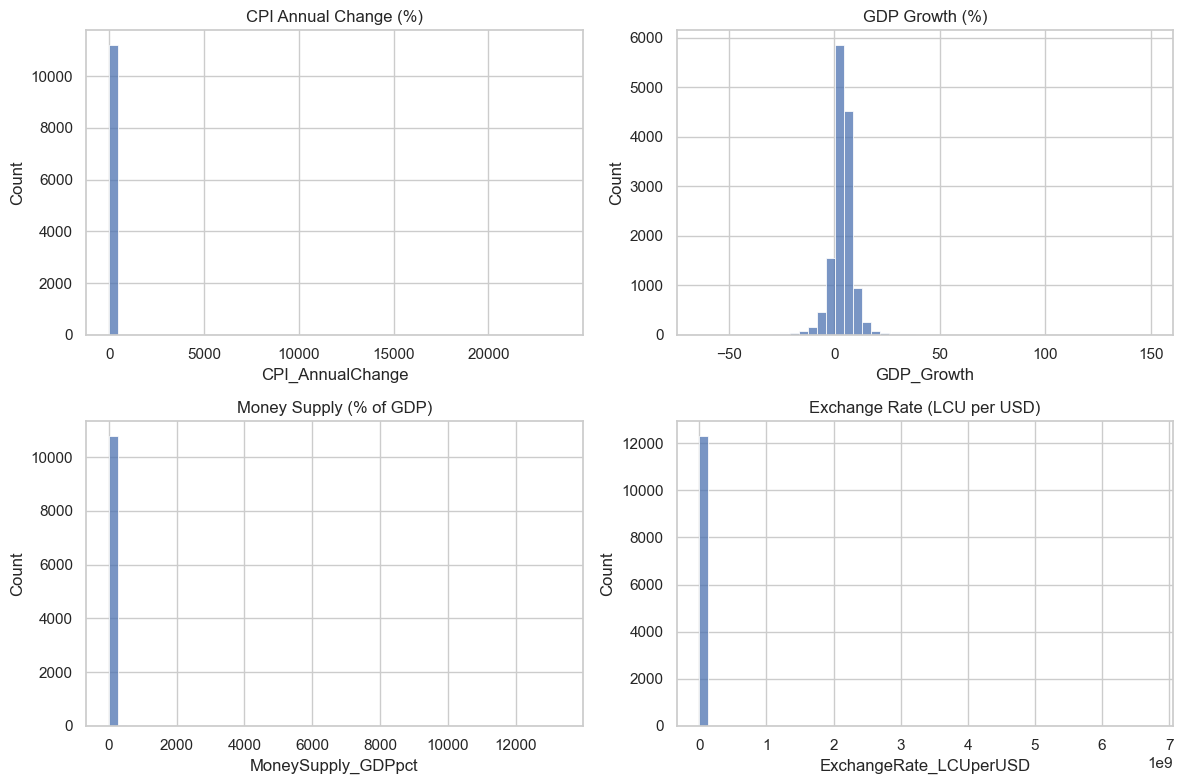

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df["CPI_AnnualChange"].dropna(), bins=50, ax=axes[0,0])
axes[0,0].set_title("CPI Annual Change (%)")

sns.histplot(df["GDP_Growth"].dropna(), bins=50, ax=axes[0,1])
axes[0,1].set_title("GDP Growth (%)")

sns.histplot(df["MoneySupply_GDPpct"].dropna(), bins=50, ax=axes[1,0])
axes[1,0].set_title("Money Supply (% of GDP)")

sns.histplot(df["ExchangeRate_LCUperUSD"].dropna(), bins=50, ax=axes[1,1])
axes[1,1].set_title("Exchange Rate (LCU per USD)")

plt.tight_layout()
plt.show()

### KDE plot with sampling

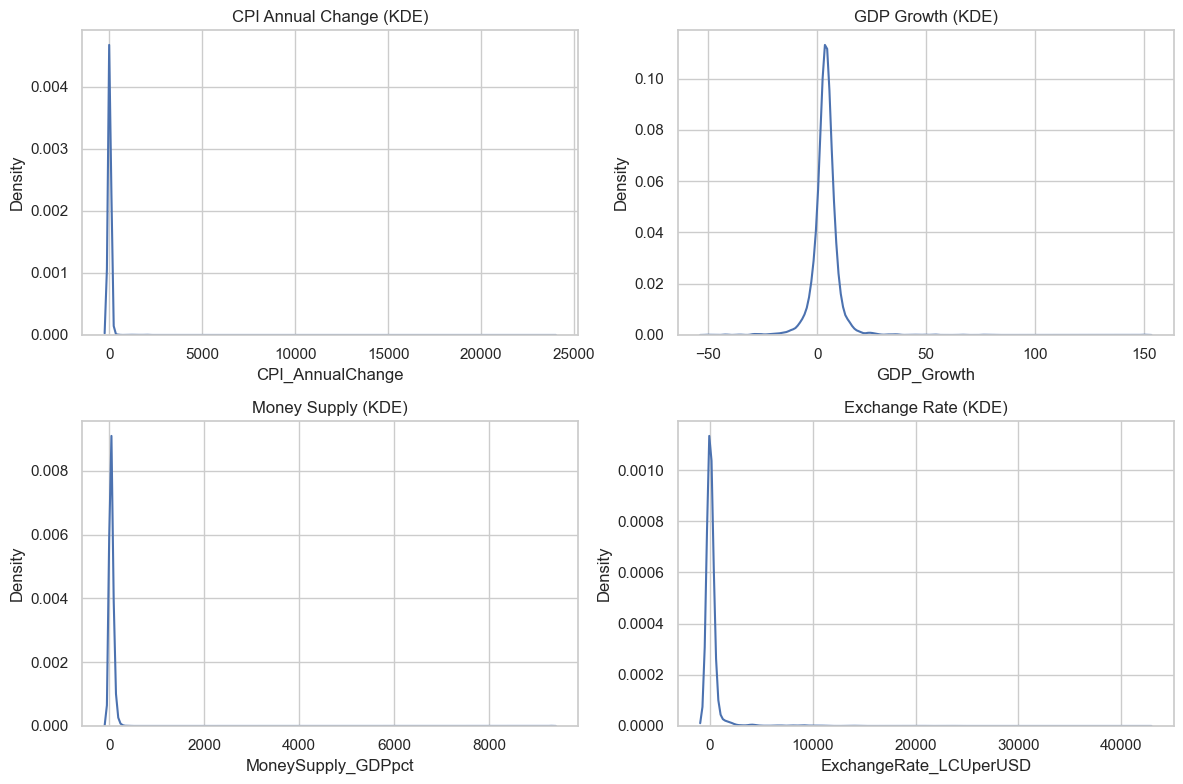

In [4]:
# Sample a subset (to speed up KDE rendering)
sample_df = df.sample(n=5000, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.kdeplot(sample_df["CPI_AnnualChange"].dropna(), ax=axes[0,0])
axes[0,0].set_title("CPI Annual Change (KDE)")

sns.kdeplot(sample_df["GDP_Growth"].dropna(), ax=axes[0,1])
axes[0,1].set_title("GDP Growth (KDE)")

sns.kdeplot(sample_df["MoneySupply_GDPpct"].dropna(), ax=axes[1,0])
axes[1,0].set_title("Money Supply (KDE)")

sns.kdeplot(sample_df["ExchangeRate_LCUperUSD"].dropna(), ax=axes[1,1])
axes[1,1].set_title("Exchange Rate (KDE)")

plt.tight_layout()
plt.show()

### Outlier-Capped & Transformed View

Notice from previous plot that some indicators contain **extreme outliers**.
(e.g., CPI Annual Change > 20,000%, Money Supply > 12,000%, and Exchange Rates in millions).
These outliers dominate the histograms and flatten the main distribution.

To address this, we apply two strategies:

1. **Percentile capping (1st–99th)** to reduce the effect of extreme spikes.
2. **Log transformation** for indicators with heavy skew (CPI, Money Supply, Exchange Rate)
so that the main distribution becomes more visible. <br>
GDP Growth is already well-behaved, so we keep it linear.

C:\Users\namor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


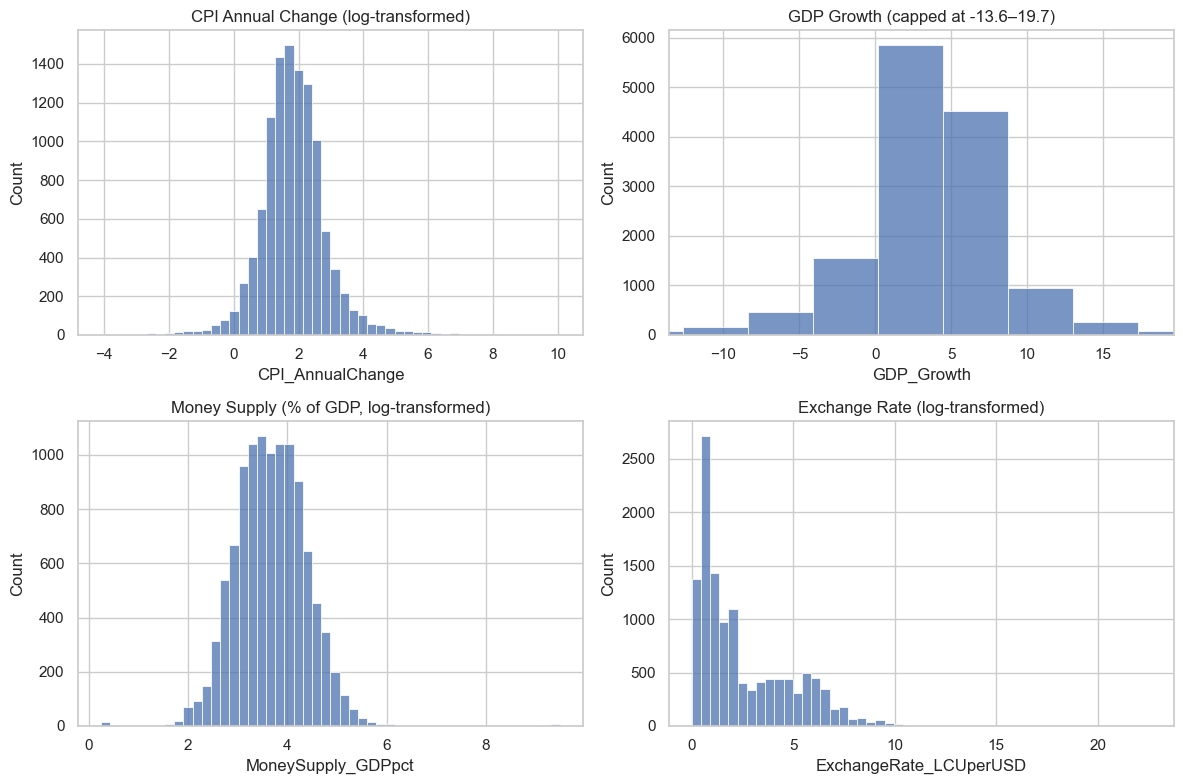

In [5]:
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define a helper to get percentile caps
def get_cap(series, lower=1, upper=99):
    return series.dropna().quantile(lower/100), series.dropna().quantile(upper/100)

# CPI (log transform)
sns.histplot(np.log1p(df["CPI_AnnualChange"].dropna()), bins=50, ax=axes[0,0])
axes[0,0].set_title("CPI Annual Change (log-transformed)")

# GDP Growth (percentile cap only)
low, high = get_cap(df["GDP_Growth"])
sns.histplot(df["GDP_Growth"].dropna(), bins=50, ax=axes[0,1])
axes[0,1].set_xlim(low, high)
axes[0,1].set_title(f"GDP Growth (capped at {low:.1f}–{high:.1f})")

# Money Supply (log transform)
sns.histplot(np.log1p(df["MoneySupply_GDPpct"].dropna()), bins=50, ax=axes[1,0])
axes[1,0].set_title("Money Supply (% of GDP, log-transformed)")

# Exchange Rate (log transform)
sns.histplot(np.log1p(df.loc[df["ExchangeRate_LCUperUSD"] > 0, "ExchangeRate_LCUperUSD"]), 
             bins=50, ax=axes[1,1])
axes[1,1].set_title("Exchange Rate (log-transformed)")

plt.tight_layout()
plt.show()

**Observation:** 

- **CPI Annual Change** and **Money Supply (% GDP)** are highly skewed with a long right tail. Such extreme skewness hides the distribution of the majority of countries, but log transformation reveals their normal-range variation.  
- **GDP Growth** is relatively stable and resembles a normal distribution centered around 0–5%, making it easier to interpret and model.  
- **Exchange Rates** vary across several orders of magnitude (including hyperinflation cases). The log transform highlights three distinct clusters: hard pegs, mid-range floats, and hyperinflation.

Overall, this confirms the importance of **outlier handling and transformations** before moving into correlation analysis or risk index construction. 

## 5. Temporal Trends

We visualize how each indicator evolves across time for a few **sample countries** (United States, China, India, Indonesia).
- For **CPI, Money Supply, and Exchange Rate**, we apply `log(1+x)` transformation to reduce the impact of extreme outliers.
- For **GDP Growth**, we keep the raw values since the distribution is already reasonable.
- Subplots allow us to compare all indicators in a single view.

C:\Users\namor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


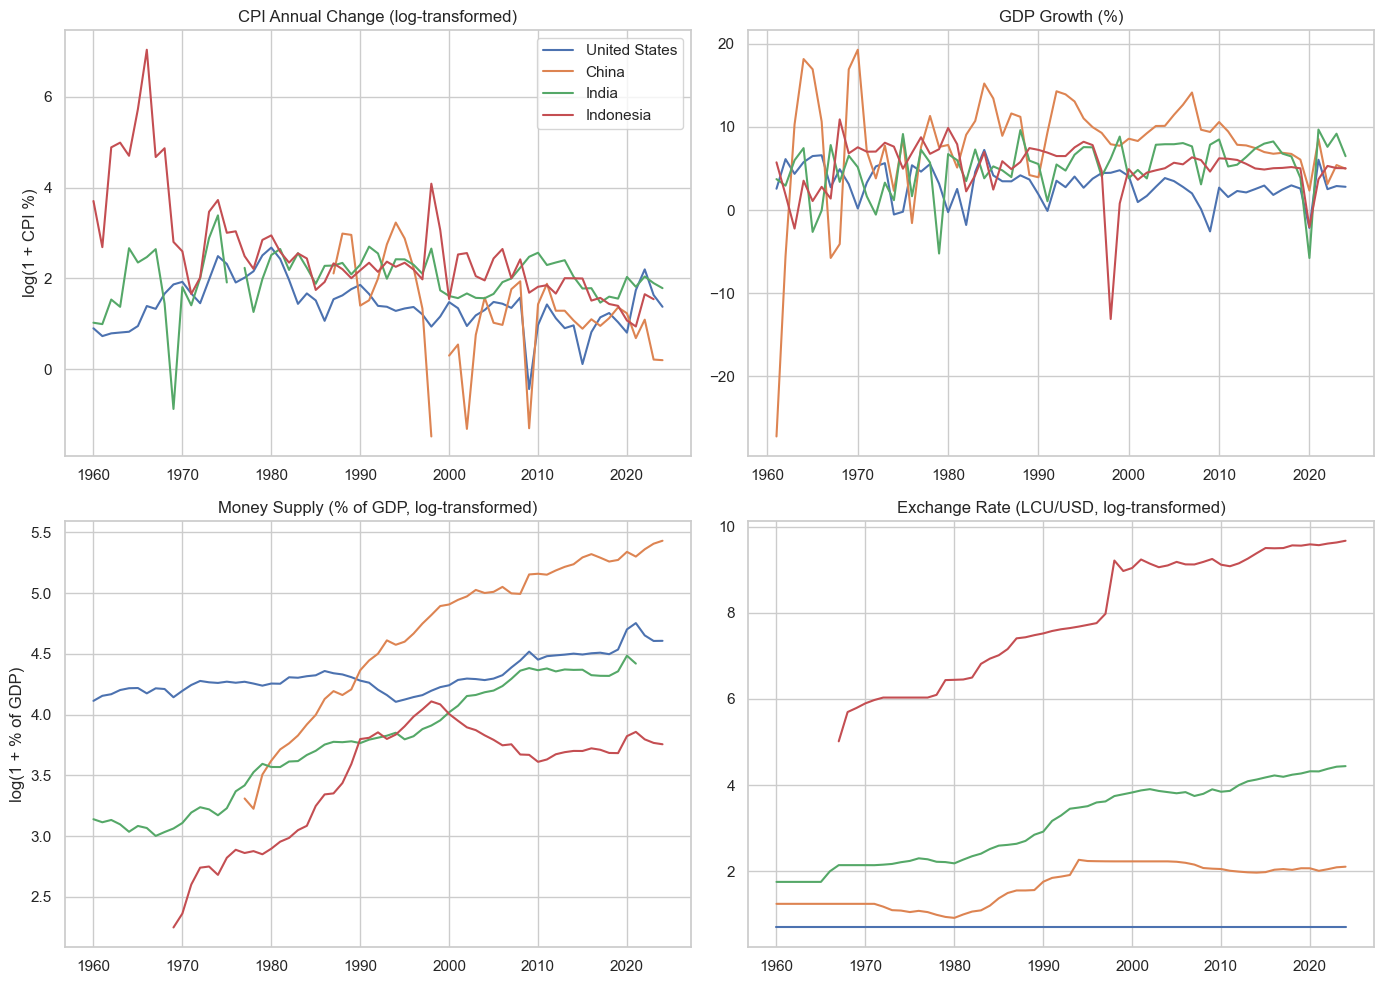

In [6]:
sample_countries = ["United States", "China", "India", "Indonesia"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CPI (log)
for c in sample_countries:
    subset = df[df["Country Name"] == c]
    axes[0,0].plot(subset["Year"], np.log1p(subset["CPI_AnnualChange"]), label=c)
axes[0,0].set_title("CPI Annual Change (log-transformed)")
axes[0,0].set_ylabel("log(1 + CPI %)")
axes[0,0].legend()

# GDP Growth (raw)
for c in sample_countries:
    subset = df[df["Country Name"] == c]
    axes[0,1].plot(subset["Year"], subset["GDP_Growth"], label=c)
axes[0,1].set_title("GDP Growth (%)")

# Money Supply (log)
for c in sample_countries:
    subset = df[df["Country Name"] == c]
    axes[1,0].plot(subset["Year"], np.log1p(subset["MoneySupply_GDPpct"]), label=c)
axes[1,0].set_title("Money Supply (% of GDP, log-transformed)")
axes[1,0].set_ylabel("log(1 + % of GDP)")

# Exchange Rate (log)
for c in sample_countries:
    subset = df[df["Country Name"] == c]
    axes[1,1].plot(subset["Year"], np.log1p(subset["ExchangeRate_LCUperUSD"]), label=c)
axes[1,1].set_title("Exchange Rate (LCU/USD, log-transformed)")

plt.tight_layout()
plt.show()

**Observation:**  
United States and China display relatively stable inflation and monetary trends over time, while India and Indonesia exhibit more volatility, especially in CPI and Exchange Rates. This suggests emerging economies tend to experience larger fluctuations compared to advanced economies.  


## 6. Correlation Analysis

We now examine the **relationships between indicators.**
- Because some indicators are skewed with heavy tails, we calculate correlations using both **raw** and **log-transformed** values.
- This helps us see whether extreme outliers drive the correlations

C:\Users\namor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


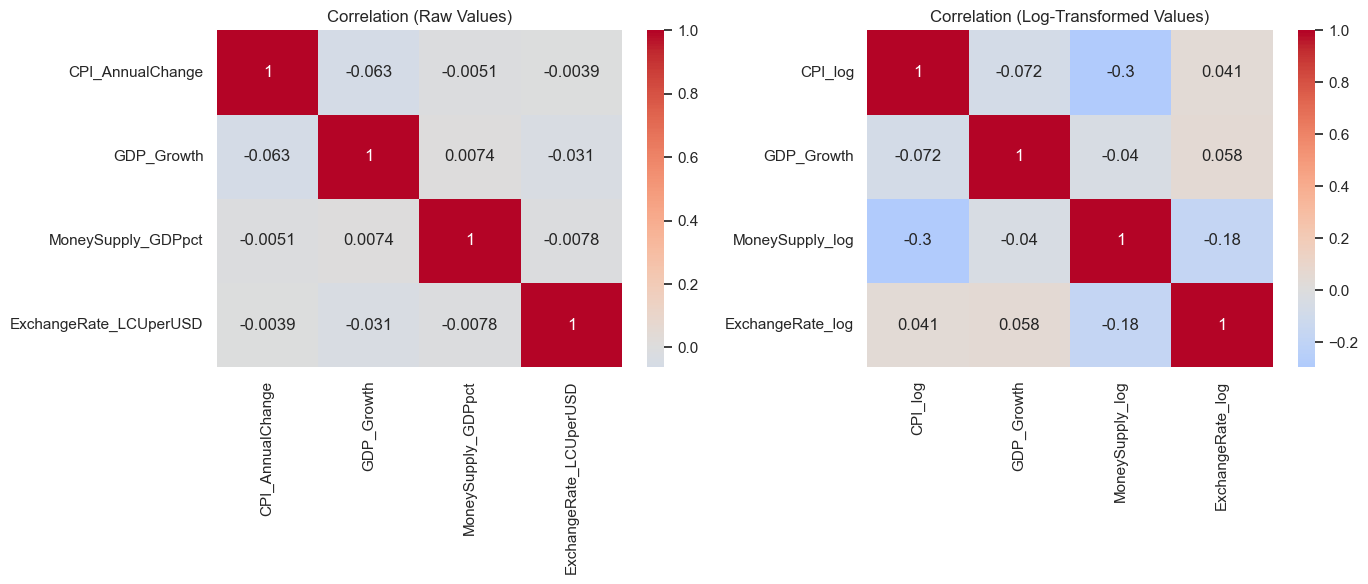

In [7]:
# Raw correlation
corr_raw = df[["CPI_AnnualChange", "GDP_Growth", 
               "MoneySupply_GDPpct", "ExchangeRate_LCUperUSD"]].corr()

# Log-transformed (add 1 before log to handle zeros)
df_log = df.copy()
df_log["CPI_log"] = np.log1p(df["CPI_AnnualChange"])
df_log["MoneySupply_log"] = np.log1p(df["MoneySupply_GDPpct"])
df_log["ExchangeRate_log"] = np.log1p(df["ExchangeRate_LCUperUSD"])
corr_log = df_log[["CPI_log", "GDP_Growth", "MoneySupply_log", "ExchangeRate_log"]].corr()

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(corr_raw, annot=True, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation (Raw Values)")

sns.heatmap(corr_log, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation (Log-Transformed Values)")

plt.tight_layout()
plt.show()

**Observation:**  
Correlation patterns differ between raw and log-transformed values. Using log values reduces the distortion from outliers. Interestingly, **CPI and Money Supply** show a mild negative correlation (~ -0.3), suggesting that countries with deeper financial systems (higher money supply relative to GDP) often experience lower inflation.  

## 7. Country-Level Patterns

We summarize **country-level averages** to detect persistent outliers.
- Use **log-transformed values** for CPI, Money Supply, Exchange Rate to avoid domination by extreme cases.
- Compare with GDP Growth in raw %.

In [8]:
country_avg = df_log.groupby("Country Name")[["CPI_log", "GDP_Growth", "MoneySupply_log", "ExchangeRate_log"]].mean()

# Sort by CPI (inflation risk proxy)
high_inflation = country_avg.sort_values("CPI_log", ascending=False).head(10)
low_inflation  = country_avg.sort_values("CPI_log", ascending=True).head(10)

print("Top 10 Countries by Average Inflation (log CPI):")
display(high_inflation)

print("\nBottom 10 Countries by Average Inflation (log CPI):")
display(low_inflation)

Top 10 Countries by Average Inflation (log CPI):


,CPI_log,GDP_Growth,MoneySupply_log,ExchangeRate_log
Country Name,,,,
Angola,4.019061,3.367839,3.293437,1.901160
"Venezuela, RB",3.916508,2.805467,3.372862,0.469292
"Congo, Dem. Rep.",3.802705,1.987230,2.330993,2.535009
Belarus,3.398165,2.401092,3.244928,0.529514
Brazil,3.312061,3.858992,3.643823,0.592977
Uruguay,3.184989,2.204907,3.679858,1.566784
Zambia,3.131123,3.329607,3.160633,1.000529
South Sudan,3.126475,-4.925338,3.238727,4.093680
Turkiye,3.099972,4.761685,3.456657,0.558098



Bottom 10 Countries by Average Inflation (log CPI):


,CPI_log,GDP_Growth,MoneySupply_log,ExchangeRate_log
Country Name,,,,
Nauru,0.064674,-1.384118,NaN,0.771796
Tuvalu,0.405852,2.572103,NaN,0.922415
Cayman Islands,0.476991,1.536939,NaN,0.597563
Brunei Darussalam,0.688559,0.856541,4.248836,1.076093
New Caledonia,0.689863,3.821549,NaN,4.610947
Oman,0.795942,7.644562,3.359287,0.318634
Japan,0.910715,3.318273,5.066545,5.131182
Bosnia and Herzegovina,0.911823,5.937548,3.933611,0.984889
Sint Maarten (Dutch part),0.950727,1.205656,NaN,1.026042


**Observation:**  
Country-level averages highlight consistent outliers. For example, **Angola and Venezuela** appear among the top high-inflation countries, while **Nauru, Tuvalu, and Switzerland** are among the most stable. This confirms that persistent inflation risk can be identified by averaging long-term data, not only looking at single-year spikes.  

## 8. Insights Recap

From our exploratory analysis so far:

- **Distributions:** GDP Growth is relatively centered, while CPI, Money Supply, and Exchange Rate are heavily skewed — better visualized with log transforms.
- **Temporal Trends:** Emerging economies show more volatility, while advanced economies have smoother paths.
- **Correlations:** Raw values can be misleading; log transforms reveal clearer relationships between money supply, exchange rate, and inflation.
- **Country-Level Patterns:** Some economies show consistently high inflation pressure, while others remain stable.

This sets the stage for **Step 03 (Feature Engineering & Risk Index Construction)**, where we’ll design composite measures of inflation risk.

## 9. Save EDA Outputs

As a final step in this notebook, we save an aggregated summary at the country level.  
This file (`eda_country_summary.csv`) can be used for later visualization on Power BI or as a reference to validate our inflation risk index in Step 03.

In [9]:
# Country-level average for key indicators
eda_summary = df_log.groupby("Country Name")[[
    "CPI_AnnualChange", 
    "GDP_Growth",
    "MoneySupply_GDPpct",
    "ExchangeRate_LCUperUSD",
    "CPI_log",  
    "MoneySupply_log", 
    "ExchangeRate_log"
]].mean().reset_index()

# Save to intermediate folder
eda_output_file = "data_intermediate/eda_country_summary.csv"
eda_summary.to_csv(eda_output_file, index=False)
print(f"EDA summary saved to: {eda_output_file}")

EDA summary saved to: data_intermediate/eda_country_summary.csv


> 💡 **Note:**  
We save both **raw averages** (for visualization & communication) and **log-transformed averages** (for modeling & stability).  
This ensures flexibility: stakeholders can view interpretable raw values, while the risk index construction can leverage log features that handle skewness and outliers.  

## 10. Summary

In this notebook, we performed exploratory analysis on the cleaned dataset.  
Key steps included:

- **4. (Univariate Analysis):** We explored the distributions of CPI, GDP growth, money supply, and exchange rates, handling outliers with capped and log-transformed views.  
- **5. (Temporal Trends):** We visualized how each indicator evolved over time for sample countries.  
- **6. (Correlation Analysis):** We checked relationships between indicators with a correlation matrix.  
- **7. (Country-Level Patterns):** We identified countries with extreme inflation and growth patterns.  
- **8. (Insights Recap):** We summarized the main findings from the EDA.  
- **9. (Save EDA Outputs):** We exported country-level averages for further use in Power BI and as a baseline for the next feature engineering step.

This EDA provided the first statistical and visual insights into inflation-related macroeconomic indicators.  
In the next notebook (`03_feature_engineering_risk_index.ipynb`), we will construct composite metrics and a risk index.